# Using Sklearn pipelines for hyperparameter tuning

Now that this course has developed ideas hyperparameters as they relate to a model's ability to adapt their complexity, it may be helpful to further reinforce the use of tools for tuning these hyperparameters. Pipelines were introduced in CSC2621 Introduction to Data Science for the purpose of wrapping all steps of the ML pipeline into a single method call. We can also use these pipelines to streamline training and performing a grid search of model's hyperparameters. This notebook uses the titanic data set, but now incorporates all steps (from numeric and categorical encoding, data standardization, feature engineering / reduction, and model hyperparameter searching)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import TruncatedSVD

from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score

We start with reading in the whole titanic data set using pandas. For this case, the data set has mixed feature types but we still want to make use of all of them.

We are going to use the survived label as the response.

In [2]:
df = pd.read_csv("titanic.csv")
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
print(df.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


We can see that the dataset is not quite balanced, we can address this in the training/test sampling process.

In [4]:
print(df['Survived'].value_counts())

Survived
0    549
1    342
Name: count, dtype: int64


We are going to manually specify the numeric versus categorical features. Some of these choices are relative and depend on the subject matter.

Do remember, even when features are numerical encoded, it may still make sense to treat them as categorical features - a prime example is PassengerID where we might not expect there to be a relationship between passengers that would be encoded by the magnitude of the ID. In light of this features - as you might expect - we may or may not get a lot of information for survival from some of these features.

In [5]:
numeric_features = ["Pclass", "Age", "SibSp", "Parch", "Fare"]
categorical_features = ["PassengerId", "Name", "Sex", "Ticket", "Cabin", "Embarked"]

In [6]:
for col_name in categorical_features:
    df[col_name] = df[col_name].astype("category")

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    category
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    int64   
 3   Name         891 non-null    category
 4   Sex          891 non-null    category
 5   Age          714 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    category
 9   Fare         891 non-null    float64 
 10  Cabin        204 non-null    category
 11  Embarked     889 non-null    category
dtypes: category(6), float64(2), int64(4)
memory usage: 156.0 KB


As previously mentioned, we can ensure that we maintain the original class balance by stratifying our train/test split using the survived label.

In [8]:
df_train, df_test = train_test_split(df, stratify=df["Survived"],random_state=42)
y_train = df_train["Survived"]
y_test = df_test["Survived"]
X_train = df_train.drop(columns='Survived')
X_test = df_test.drop(columns='Survived')

We can now define preprocessing steps for numerical and categorical features and then pair them together in the preprocessor structure.

A demo pipeline is then defined using the preprocessor and a single classifier (logistic regression).

In [9]:
numeric_transformer = Pipeline(
    steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="infrequent_if_exist"))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
classifier = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

In [10]:
classifier.fit(X_train, y_train)
print(f"model score: {classifier.score(X_test, y_test):.3f}")

model score: 0.798


This could be a baseline model, bu serves more as a single demo for this workbook.

We can further define individual pipelines using the classifiers that we have discussed in this class. Additionally, we have added an additional feature reduction step using PCA that returns only the top 10 principal components.

Random states are used to control the output on subsequent evaluations.

In [11]:
pipe_lr = Pipeline([("preprocessor", preprocessor),
			('clf', LogisticRegression(random_state=42))])

pipe_lr_pca = Pipeline([("preprocessor", preprocessor),
			('pca', TruncatedSVD(n_components=10)),
			('clf', LogisticRegression(random_state=42))])

pipe_rf = Pipeline([("preprocessor", preprocessor),
			('clf', DecisionTreeClassifier(random_state=42))])

pipe_rf_pca = Pipeline([("preprocessor", preprocessor),
			('pca', TruncatedSVD(n_components=10)),
			('clf', DecisionTreeClassifier(random_state=42))])

pipe_svm = Pipeline([("preprocessor", preprocessor),
			('clf', SVC(random_state=42, probability=True))])

pipe_svm_pca = Pipeline([("preprocessor", preprocessor),
			('pca', TruncatedSVD(n_components=10)),
			('clf', SVC(random_state=42))]) # , probability=True results in substantial slowdown

We can now define the hyperparameter grid points that we want to sample using a cross validation grid search approach.

This requires a dictionary object that defines the hyperparameters to be tuned. The dictionaries use the component name (in this case clf) with a double underscore separating the hyperparameter parameter name. This approach can use both numerical values, as well as categorical (string values).

In [12]:
param_range = [0.1, 1, 10, 100]
param_range_fl = [1.0, 0.5, 0.1]
param_range_tree = [2, 4, 5, 7]

grid_params_lr = [{'clf__penalty': ['l1', 'l2'],
		'clf__C': param_range_fl,
		'clf__solver': ['liblinear']}] 

grid_params_rf = [{'clf__criterion': ['gini', 'entropy'],
		'clf__min_samples_leaf': param_range_tree,
		'clf__max_depth': param_range_tree,
		'clf__min_samples_split': param_range_tree}]

grid_params_svm = [{'clf__kernel': ['linear', 'rbf'], 
		'clf__C': param_range}]

In [13]:
jobs = -1

gs_lr = GridSearchCV(estimator=pipe_lr,
			param_grid=grid_params_lr,
			scoring='accuracy',
			cv=5) 
			
gs_lr_pca = GridSearchCV(estimator=pipe_lr_pca,
			param_grid=grid_params_lr,
			scoring='accuracy',
			cv=5)
			
gs_rf = GridSearchCV(estimator=pipe_rf,
			param_grid=grid_params_rf,
			scoring='accuracy',
			cv=5, 
			n_jobs=jobs)

gs_rf_pca = GridSearchCV(estimator=pipe_rf_pca,
			param_grid=grid_params_rf,
			scoring='accuracy',
			cv=5, 
			n_jobs=jobs)

gs_svm = GridSearchCV(estimator=pipe_svm,
			param_grid=grid_params_svm,
			scoring='accuracy',
			cv=5,
			n_jobs=jobs)

gs_svm_pca = GridSearchCV(estimator=pipe_svm_pca,
			param_grid=grid_params_svm,
			scoring='accuracy',
			cv=5,
			n_jobs=jobs)

In [14]:
# List of pipelines for ease of iteration
grids = [gs_lr, gs_lr_pca, gs_rf, gs_rf_pca, gs_svm, gs_svm_pca]

# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0: 'Logistic Regression', 1: 'Logistic Regression w/PCA', 
		2: 'Decision Tree', 3: 'Decision Tree w/PCA', 
		4: 'Support Vector Machine', 5: 'Support Vector Machine w/PCA'}

In [16]:
print('Performing model optimizations...')
best_acc = 0.0
best_idx = 0
best_gs = ''
for idx, gs in enumerate(grids):
    print(f'\nEstimator: {grid_dict[idx]}')	
    # Fit grid search	
    gs.fit(X_train, y_train)
    # Best params
    print(f'Best params: {gs.best_params_}')
    # Best training data accuracy
    print(f'Best training accuracy: {gs.best_score_:.3f}')
    # Predict on test data with best params
    y_pred = gs.predict(X_test)
    # Test data accuracy of model with best params
    print(f'Test set accuracy score for best params: {accuracy_score(y_test, y_pred):.3f}')

    # Track best (highest test accuracy) model
    if accuracy_score(y_test, y_pred) > best_acc:
        best_acc = accuracy_score(y_test, y_pred)
        best_gs = gs
        best_idx = idx
print(f'\nClassifier with best test set accuracy: {grid_dict[best_idx]}')

Performing model optimizations...

Estimator: Logistic Regression
Best params: {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Best training accuracy: 0.810
Test set accuracy score for best params: 0.789

Estimator: Logistic Regression w/PCA
Best params: {'clf__C': 0.1, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Best training accuracy: 0.813
Test set accuracy score for best params: 0.794

Estimator: Decision Tree
Best params: {'clf__criterion': 'gini', 'clf__max_depth': 4, 'clf__min_samples_leaf': 7, 'clf__min_samples_split': 2}
Best training accuracy: 0.811
Test set accuracy score for best params: 0.771

Estimator: Decision Tree w/PCA
Best params: {'clf__criterion': 'entropy', 'clf__max_depth': 7, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 5}
Best training accuracy: 0.799
Test set accuracy score for best params: 0.776

Estimator: Support Vector Machine
Best params: {'clf__C': 10, 'clf__kernel': 'rbf'}
Best training accuracy: 0.838
Test set accuracy 

In using cross-fold validation, we are able to detect overfitting and underfitting of our models. The training structure then retains the best performant model on the left out validation data sets.

In [17]:
print(best_gs.best_params_)

{'clf__C': 10, 'clf__kernel': 'rbf'}


We can then evaluate the best performant model on our reserved test dataset and construct the ROC curve for this binary classification task.

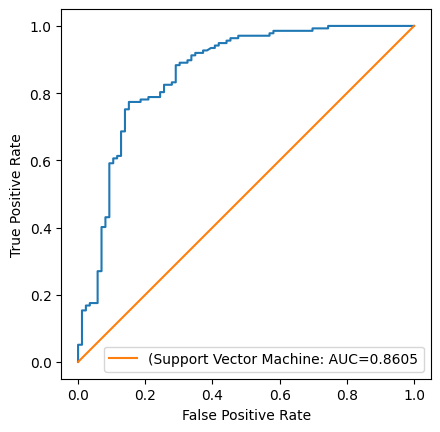

In [18]:
pred_proba = best_gs.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test==0, pred_proba[:,0])

plt.plot(fpr, tpr)
plt.plot([0.0, 1.0], [0.0, 1.0], label=f"({grid_dict[best_idx]}: AUC={roc_auc_score(y_test == 0, pred_proba[:,0]):.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.axis('square')
plt.legend()
plt.show()